# 0. Imports

In [38]:
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

# 1. Dataset

In [3]:
os.system("wget https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar")

0

In [ ]:
# to try
os.system("mkdir ./dataset")
os.system("tar -xvf streethazards_train.tar -C ./dataset")

In [6]:
os.system("tar -xvf streethazards_train.tar")

0

In [18]:
image_folder = "./train/images/training/t1-3"
mask_folder = "./train/annotations/training/t1-3"

In [36]:
len_dataset = len(os.listdir(image_folder))

idx = np.random.choice(len_dataset, size=None)

sample_image = read_image(os.path.join(image_folder,
                                sorted(os.listdir(image_folder))[idx]
                                ))
sample_mask = read_image(os.path.join(mask_folder,
                                sorted(os.listdir(image_folder))[idx]
                                ))

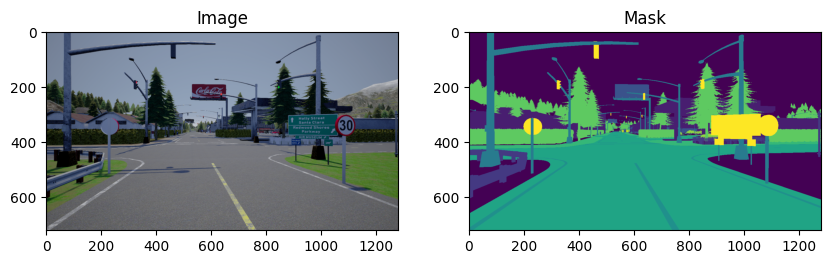

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image.permute(1,2,0))
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(sample_mask.permute(1,2,0))
plt.title("Mask")

plt.show()

## most of the get_item has been taken from [this link](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In the code below, we are wrapping images, bounding boxes and masks into torchvision.tv_tensors.TVTensor classes so that we will be able to apply torchvision built-in transformations (new Transforms API) for the given object detection and segmentation task. Namely, image tensors will be wrapped by torchvision.tv_tensors.Image, bounding boxes into torchvision.tv_tensors.BoundingBoxes and masks into torchvision.tv_tensors.Mask. As torchvision.tv_tensors.TVTensor are torch.Tensor subclasses, wrapped objects are also tensors and inherit the plain torch.Tensor API.

In [77]:
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class StreetHazardsTrain(Dataset):
    def __init__(self, split, transforms=None):
        self.split = split

        if self.split in ["train", "training"]:
            self.img_root = "./train/images/training/t1-3"
            self.mask_root = "./train/annotations/training/t1-3"
        else:
            self.img_root = "./train/images/validation/t4"
            self.mask_root = "./train/annotations/validation/t4"

        self.transforms = transforms
        self.imgs = sorted(os.listdir(self.img_root))
        self.masks = sorted(os.listdir(self.mask_root))


    def __getitem__(self, idx):
        img = read_image(os.path.join(self.img_root, self.imgs[idx]))
        mask = read_image(os.path.join(self.mask_root, self.masks[idx]))

        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        labels = torch.tensor([obj_id.item() for obj_id in obj_ids], dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        # i guess this is not useful in our scenario
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, mask, target


    def __len__(self):
        return len(self.imgs)

In [78]:
train_dataset = StreetHazardsTrain(split="train")
validation_dataset = StreetHazardsTrain(split="validation")

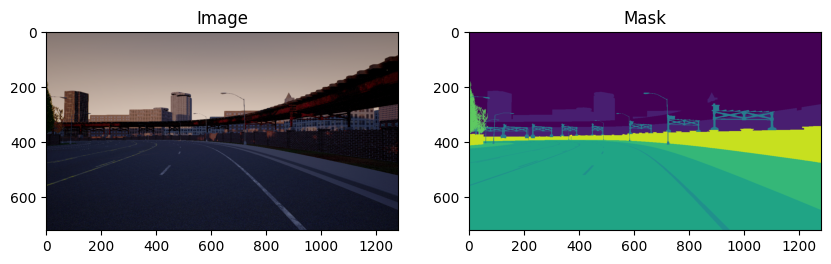

In [79]:
sample_image, sample_mask, target = train_dataset[20]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sample_image.permute(1,2,0))
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(sample_mask.permute(1,2,0))
plt.title("Mask")

plt.show()

In [81]:
sample_image, sample_mask, target = train_dataset[20]

In [84]:
sample_image.shape

torch.Size([4, 720, 1280])

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"Using {device}.")

Using cuda.
